In [368]:
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt 
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from dask import dataframe as dd

In [369]:
fileDataStatic=pd.read_csv("./WaveStatic.dat", header = 0, sep='\s+')

new_num_rows = 1000

indices = np.linspace(0, fileDataStatic['x'].shape[0] - 1, new_num_rows, dtype=int)

fileDataStatic = fileDataStatic.iloc[indices].reset_index(drop=True)

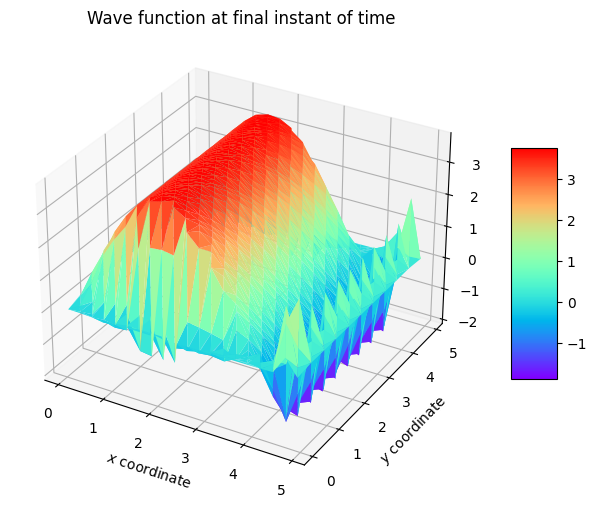

In [370]:

def plotFinalTimeWave() :
    fig = plt.figure(figsize=(10,6))
    ax1 = fig.add_subplot(111, projection='3d')

    mycmap = plt.get_cmap('rainbow')
    ax1.set_title('Wave function at final instant of time')
    ax1.set_xlabel('$x$ coordinate')
    ax1.set_ylabel('$y$ coordinate')

    surf1 = ax1.plot_trisurf(fileDataStatic['x'], fileDataStatic['y'], fileDataStatic['f'], cmap=mycmap)
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    plt.show()

plotFinalTimeWave()

    

In [371]:
#del fileDataStatic

In [372]:
fileDataDynamic=pd.read_csv("./Wave.dat", header = 0, sep='\s+')

new_num_rows = 50000

indices = np.linspace(0, fileDataDynamic['x'].shape[0] - 1, new_num_rows, dtype=int)

fileData = fileDataDynamic.iloc[indices].reset_index(drop=True)

fileData


,x,y,t,f
0,0.05,0.05,1,-0.001057
1,0.05,0.20,1,0.013290
2,0.05,0.40,1,0.098416
3,0.05,0.55,1,0.157664
4,0.05,0.75,1,0.158187
...,...,...,...,...
49995,4.90,4.15,19,0.128915
49996,4.90,4.35,19,0.129437
49997,4.90,4.50,19,0.237227
49998,4.90,4.70,19,0.121400


In [373]:
def PrepareData(num_data=1000, random=True):
    
    x_data = fileData['x']
    y_data = fileData['y'] 
    t_data = fileData['t'] 
    f_data = fileData['f'] 

    # Número desejado de linhas após a redução

    x_data.reset_index(drop=True)
    print(x_data)
    
    #print("x_data", x_data)
    N = x_data.shape[0]
    T = t_data.shape[0]
    
    print("N", N)
    print("T", T)
    
    # Pick random data.
    if random:
        idx = np.random.choice(N, num_data, replace=False)
    else:
        idx = np.arange(0, N*T)
    
    print("idx", type(idx))

    x = x_data[idx].values # NT x 1
    y = y_data[idx].values # NT x 1
    t = t_data[idx].values# NT x 1
    f = f_data[idx].values # NT x 1
 
    return (x,y,t,f)

In [374]:


x_train, y_train, t_train, f_train = [fileData['x'].values, fileData['y'].values, fileData['t'].values, fileData['f'].values]

print("x_train",x_train)

x_train [0.05 0.05 0.05 ... 4.9  4.9  4.9 ]


In [375]:
x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

In [376]:
f = sn.Functional("f", [x, y, t], 8*[40], 'tanh')

In [377]:
v0 = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="v0")

print("v0:", v0.value)

2023-08-26 15:28:03.679599: W tensorflow/c/c_api.cc:291] Operation '{name:'D40b_89_1/bias/Assign' id:67997 op device:{requested: '', assigned: ''} def:{{{node D40b_89_1/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](D40b_89_1/bias, D40b_89_1/bias/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


v0: [0.7342011]


In [378]:
f_xx = sn.diff(f, x, order=2)
f_yy = sn.diff(f, y, order=2)
f_tt = sn.diff(f, y, order=2)

PDE = f_xx - v0*(f_xx + f_yy)

#print(PDE.shape)

sn.PDE(PDE, name="wave")

In [379]:
C_LEFT = (x==0.)*0*sn.abs(f)
C_TOP = (y==50.)*0*sn.abs(f)
C_RIGHT = (x==50.)*0*sn.abs(f)
C_BOTTOM = (y==0.)*0*sn.abs(f)

print(C_LEFT)

In [380]:
model = sn.SciModel(
    inputs=[x, y, t],
    targets=[PDE, C_TOP, C_RIGHT, C_BOTTOM, C_LEFT],
    loss_func="mse",
    plot_to_file='PINN-Model.png',
    optimizer="adam"
)


In [381]:
target_pde = f_train.tolist()

target_pde = (np.array(target_pde))

target_ctop = 'zeros'
target_cright = 'zeros'
target_cbottom = 'zeros'
target_cleft = 'zeros'

target = [target_pde, target_ctop, target_cright, target_cbottom, target_cleft]
input = [x_train, y_train, t_train]

In [382]:
history = model.train(
    x_true=input,
    y_true=target,
    epochs=5000,
    batch_size=100,
    shuffle=True,
    learning_rate=0.001,
    reduce_lr_after=100,
    stop_loss_value=1e-8,
    verbose=0
)

model.save_weights('trained-wave-equation.hdf5')


Total samples: 50000 
Batch size: 100 
Total batches: 500 



2023-08-26 15:28:08.608515: W tensorflow/c/c_api.cc:291] Operation '{name:'count_98/Assign' id:69767 op device:{requested: '', assigned: ''} def:{{{node count_98/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](count_98, count_98/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-08-26 15:28:23.263442: W tensorflow/c/c_api.cc:291] Operation '{name:'training_16/Adam/D40b_87_1/kernel/v/Assign' id:72899 op device:{requested: '', assigned: ''} def:{{{node training_16/Adam/D40b_87_1/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](training_16/Adam/D40b_87_1/kernel/v, training_16/Adam/D40b_87_1/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. 


Epoch 877: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 978: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 1125: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 1260: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 1460: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 1562: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 1826: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 2138: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 2242: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 2366: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 2466: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 2566: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 2666: ReduceLROnPlateau reducing 

In [383]:
print("v0:", v0.value)

v0: [0.04821331]


Text(0, 0.5, 'Loss')

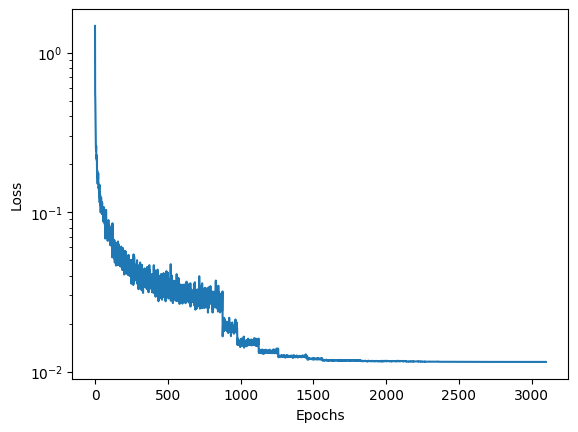

In [384]:
plt.semilogy(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [385]:
x_test, y_test, t_test = [fileData[fileData['t']==9]['x'].values, fileData[fileData['t']==9]['y'].values, fileData[fileData['t']==9]['t'].values]

In [386]:
t_test

array([9, 9, 9, ..., 9, 9, 9])

In [387]:
f_pred = f.eval(model, [x_test, y_test, t_test])

2023-08-26 17:56:18.757790: W tensorflow/c/c_api.cc:291] Operation '{name:'f_20/BiasAdd' id:68114 op device:{requested: '', assigned: ''} def:{{{node f_20/BiasAdd}} = BiasAdd[T=DT_DOUBLE, _has_manual_control_dependencies=true, data_format="NHWC"](f_20/MatMul, f_20/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


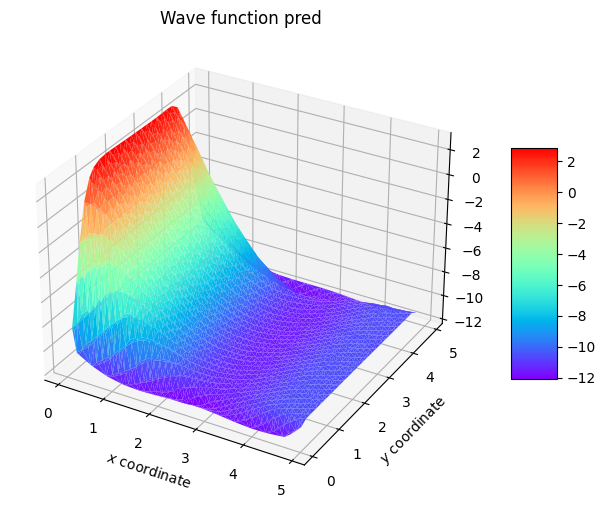

In [388]:

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(111, projection='3d')

mycmap = plt.get_cmap('rainbow')
ax1.set_title('Wave function pred')
ax1.set_xlabel('$x$ coordinate')
ax1.set_ylabel('$y$ coordinate')

surf1 = ax1.plot_trisurf(x_test, y_test, f_pred, cmap=mycmap)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

plt.show()